In [1]:
from importlib.metadata import version

pkgs = [
    "numpy",       # PyTorch & TensorFlow dependency
    "matplotlib",  # Plotting library
    "tiktoken",    # Tokenizer
    "torch",       # Deep learning library
    "tqdm",        # Progress bar
    "tensorflow",  # For OpenAI's pretrained weights
]
for p in pkgs:
    print(f"{p} version: {version(p)}")

numpy version: 2.0.2
matplotlib version: 3.10.0
tiktoken version: 0.12.0
torch version: 2.9.0+cpu
tqdm version: 4.67.1
tensorflow version: 2.19.0


## What we are going to do :

* 1. Preparing the Dataset

* 2. FineTuning the LLM

* 3. Evaluating the LLM



## 1. Preparing a dataset for supervised instruction finetuning

In [2]:
import urllib
import json
import os
import requests

def download_and_load_file(file_path, url):

    if not os.path.exists(file_path):
        with urllib.request.urlopen(url) as response:
            text_data = response.read().decode("utf-8")
        with open(file_path, "w", encoding="utf-8") as file:
            file.write(text_data)

    else:
        with open(file_path, "r", encoding="utf-8") as file:
            text_data = file.read()

    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    return data


file_path = "instruction-data.json"
url = (
    "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch"
    "/main/ch07/01_main-chapter-code/instruction-data.json"
)

data = download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


Each entry is structured as a Python Dictionary Objects containing  an
'instruction', 'input', and 'output'.

Based on the contents of this entry, the 'input' field may occasionally be empty.

In [5]:
data[0]

{'instruction': 'Evaluate the following phrase by transforming it into the spelling given.',
 'input': 'freind --> friend',
 'output': 'The spelling of the given phrase "freind" is incorrect, the correct spelling is "friend".'}

In [6]:
data[10]

{'instruction': 'What is the contraction for "will not"?',
 'input': '',
 'output': 'The contraction for "will not" is "won\'t".'}

We have to send each of these entries as inputs to the LLM.

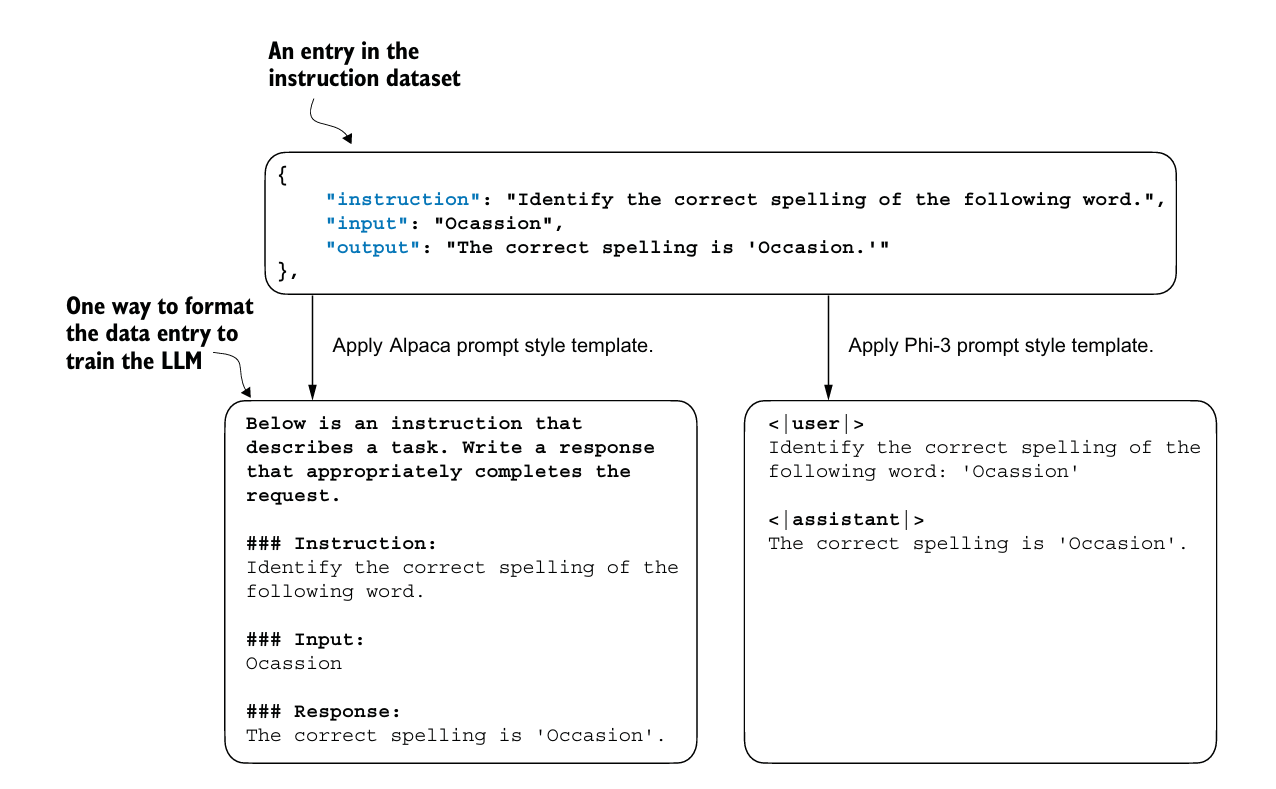

We use Alpaca-style prompt formatting, which was the original prompt template for instruction finetuning

In [7]:
def format_input(entry):
  # This function will take an entry and pass an input + instruction to the LLM.
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )

    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""

    return instruction_text + input_text

In [12]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion


In [13]:
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [14]:
# An entry with an empty input field

model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


## Dividing the Dataset into Training, Validation and Testing Set



In [15]:
train_portion = int(len(data) * 0.85)  # 85% for training
test_portion = int(len(data) * 0.1)    # 10% for testing
val_portion = len(data) - train_portion - test_portion  # Remaining 5% for validation

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

In [16]:
print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Organizing data into training batches

In [20]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
  def __init__(self, data, tokenizer, padding_token_id = 50256):
    self.data = data
    self.encoded_texts = []

    for entry in data:
      instruction_plus_input = format_input(entry)
      response_text = f"\n\n### Response:\n{entry['output']}"
      full_text = instruction_plus_input + response_text
      self.encoded_texts.append(
          tokenizer.encode(full_text)
          )
  def __getitem__(self, index):
        return self.encoded_texts[index]

  def __len__(self):
        return len(self.data)

### Building a Collate Function

####What is a Collate Function?

A collate function is responsible for taking a list of individual data sam
ples and merging them into a single batch that can be processed efficiently by the
model during training.

PyTorch default collate function is responsible to just convert things into tensors and stack them.


However, the batching process for instruction fine-tuning is a bit more involved
and requires us to create our own custom collate function that we will later plug into the DataLoader. We implement this custom collate function to handle the specific
requirements and formatting of our instruction fine-tuning dataset.

In [21]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


We are going to adopt a more sophisti
cated approach by developing a custom collate function that we can pass to the data
loader. This custom collate function pads the training examples in each batch to the
same length while allowing different batches to have different lengths.

This approach minimizes unnecessary padding by only extending
sequences to match the longest one in each batch, not the whole dataset.

In [24]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [30]:
def custom_collate_draft_1(batch, device, pad_token_id = 50256):
    # Find the longest sequence in the batch
    # We do +1 bc for every input sequence, you must have one extra token at the end to act as the final target.
    # The model needs to learn to predict <EOS> too.

    batch_max_length = max(len(item) + 1 for item in batch)
    inputs_lst = []

    for item in batch:
      new_item = item.copy() # this is to avoid modifying the original data
      new_item = new_item + [pad_token_id]
      padded = (
          new_item + [pad_token_id] * (batch_max_length - len(new_item))
      )
      inputs_lst.append(torch.tensor(padded[:-1]))


    inputs_tensor = torch.stack(inputs_lst).to(device)
    return inputs_tensor

inputs_lst is smth like :       


```
inputs_lst = [
 tensor([0, 1, 2, 3, 4]),
 tensor([5, 6, 50256, 50256, 50256]),
 tensor([7, 8, 9, 50256, 50256])
]
```

And after stacking :     


```
tensor([
 [0, 1, 2, 3, 4],
 [5, 6, 50256, 50256, 50256],
 [7, 8, 9, 50256, 50256]
])
```



In [32]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (
    inputs_1,
    inputs_2,
    inputs_3
)

print(custom_collate_draft_1(batch,device))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


### Why we do padded[-1]?

- Add EOS token at the end of each sequence: `[A, B, C] → [A, B, C, <END>]`
- Inputs = all tokens **except the last**: `[A, B, C]`
- Targets = all tokens **except the first**, shifted by 1: `[B, C, <END>]`
- This ensures **every input token has a next-token to predict**
- If we didn't remove it, it would have no target.



We have just implemented our first custom collate function to create batches from
lists of inputs. However, as we previously learned, we also need to create batches with
the target token IDs corresponding to the batch of input IDs.

 These target IDs are crucial because they represent what we want the model to
generate and what we need during training to calculate the loss for the weight
updates. That is, we modify our custom collate function to return the target token IDs
in addition to the input token IDs

In [34]:
def custom_collate_draft_2(
    batch, device,
    pad_token_id=50256
):
    # Find the longest sequence in the batch
    batch_max_length = max(len(item)+1 for item in batch)

    # Pad and prepare inputs
    inputs_lst, targets_lst = [], []

    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to max_length
        padded = (
            new_item + [pad_token_id] *
            (batch_max_length - len(new_item))
        )
        inputs = torch.tensor(padded[:-1])  # Truncate the last token for inputs
        targets = torch.tensor(padded[1:])  # Shift +1 to the right for targets
        inputs_lst.append(inputs)
        targets_lst.append(targets)

    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_lst).to(device)
    targets_tensor = torch.stack(targets_lst).to(device)
    return inputs_tensor, targets_tensor

In [36]:
inputs, targets = custom_collate_draft_2(batch, device)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])
